# BERT Text Classifier — MMHS150K Hate Speech Detection
## Google Colab Training Notebook

**Task:** Binary classification — `NotHate` vs `Hate`  
**Model:** `bert-base-uncased` fine-tuned on tweet text  
**Dataset:** MMHS150K (149,823 tweets with 3 AMT annotator labels)

### Before starting
1. **Enable GPU:** Runtime → Change runtime type → GPU (T4 / A100)
2. **Mount Drive:** Cell 2 — to save model checkpoints + results
3. **Upload data:** Cell 4 to upload `MMHS150K_GT.json` and the `splits/` folder from your local machine

---


## Step 1 — Check GPU & Install Libraries

In [1]:
# ── Confirm GPU is active ──────────────────────────────────────────────────
import subprocess, sys

result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
if result.returncode == 0:
    print(result.stdout)
else:
    print("⚠️  No NVIDIA GPU detected.")
    print("Go to: Runtime → Change runtime type → GPU  (T4 is free)")

# ── Install / upgrade required packages ───────────────────────────────────
!pip install -q --upgrade transformers>=4.40.0 accelerate tqdm scikit-learn seaborn wordcloud

Mon Feb 23 20:39:46 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# ── Core imports ───────────────────────────────────────────────────────────
import json, os, re, time, warnings
from collections import Counter
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    BertTokenizerFast,
    BertModel,
    get_linear_schedule_with_warmup,
)
from tqdm.notebook import tqdm
from sklearn.metrics import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix,
)

warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ Using device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   VRAM: 42.4 GB


## Step 2 — Mount Google Drive
All checkpoints and results are saved on Drive so they persist after the Colab session ends.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# ── Directory layout on Drive ──────────────────────────────────────────────
DRIVE_ROOT   = Path("/content/drive/MyDrive/MMHS150K_BERT")
CKPT_DIR     = DRIVE_ROOT / "checkpoints"
RESULT_DIR   = DRIVE_ROOT / "results"
DATA_DIR     = Path("/content/data")          # local Colab storage (fast I/O)

for d in [CKPT_DIR, RESULT_DIR, DATA_DIR / "splits"]:
    d.mkdir(parents=True, exist_ok=True)

print(f"✅ Drive mounted. Saving to: {DRIVE_ROOT}")

Mounted at /content/drive
✅ Drive mounted. Saving to: /content/drive/MyDrive/MMHS150K_BERT


## Step 3 — Upload Dataset Files
Upload from local machine:
- `data/MMHS150K_GT.json`
- `data/splits/train_ids.txt`
- `data/splits/val_ids.txt`
- `data/splits/test_ids.txt`

In [4]:
from google.colab import files

print("📁 Upload MMHS150K_GT.json")
uploaded = files.upload()      # select MMHS150K_GT.json
for fname, data in uploaded.items():
    dest = DATA_DIR / fname
    dest.write_bytes(data)
    print(f"   Saved {fname} → {dest}  ({len(data)/1e6:.1f} MB)")

print("\n📁 Upload split files (train_ids.txt, val_ids.txt, test_ids.txt)")
uploaded = files.upload()
for fname, data in uploaded.items():
    dest = DATA_DIR / "splits" / fname
    dest.write_bytes(data)
    print(f"   Saved {fname} → {dest}")

print("\n✅ All files uploaded.")
print("   Contents of /content/data/:")
for p in sorted(DATA_DIR.rglob("*")):
    print(f"   {p}")

📁 Upload MMHS150K_GT.json


Saving MMHS150K_GT.json to MMHS150K_GT.json
   Saved MMHS150K_GT.json → /content/data/MMHS150K_GT.json  (51.4 MB)

📁 Upload split files (train_ids.txt, val_ids.txt, test_ids.txt)


Saving train_ids.txt to train_ids.txt
Saving test_ids.txt to test_ids.txt
Saving val_ids.txt to val_ids.txt
   Saved train_ids.txt → /content/data/splits/train_ids.txt
   Saved test_ids.txt → /content/data/splits/test_ids.txt
   Saved val_ids.txt → /content/data/splits/val_ids.txt

✅ All files uploaded.
   Contents of /content/data/:
   /content/data/MMHS150K_GT.json
   /content/data/splits
   /content/data/splits/test_ids.txt
   /content/data/splits/train_ids.txt
   /content/data/splits/val_ids.txt


## Step 4 — Training Configuration
Tune the hyperparameters here. The defaults are well-tested for this dataset.

In [5]:
# ═══════════════════════════════════════════════════════════════════════════
#  CONFIGURATION — edit these values as needed
# ═══════════════════════════════════════════════════════════════════════════

# Paths
GT_PATH   = DATA_DIR / "MMHS150K_GT.json"
SPLIT_DIR = DATA_DIR / "splits"

# Model
MODEL_NAME  = "bert-base-uncased"   # swap to "bert-large-uncased" for better accuracy
BINARY      = True                   # True = Hate/NotHate;  False = 6-class
NUM_CLASSES = 2 if BINARY else 6

# Tokenisation
MAX_LEN = 96                         # 96 covers 99% of tweets; increase to 128 if budget allows

# Training
EPOCHS          = 5                  # 3–5 is enough; set to 3 on free T4
BATCH_SIZE      = 64                 # 64 on T4 16 GB; reduce to 32 if OOM
LR              = 2e-5
WEIGHT_DECAY    = 0.01
WARMUP_RATIO    = 0.1
GRAD_CLIP       = 1.0
DROPOUT         = 0.3

# Early stopping
PATIENCE        = 2                  # stop after 2 epochs without val F1 improvement

# Reproducibility
SEED            = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Label maps
LABEL_MAP_BINARY = {0: "NotHate", 1: "Hate"}
LABEL_MAP_6      = {0:"NotHate", 1:"Racist", 2:"Sexist",
                    3:"Homophobe", 4:"Religion", 5:"OtherHate"}
LABEL_MAP        = LABEL_MAP_BINARY if BINARY else LABEL_MAP_6
LABEL_NAMES      = [LABEL_MAP[i] for i in range(NUM_CLASSES)]

print("✅ Config set:")
print(f"   Model      : {MODEL_NAME}")
print(f"   Task       : {'Binary' if BINARY else '6-Class'} | {NUM_CLASSES} classes")
print(f"   Epochs     : {EPOCHS}  |  Batch: {BATCH_SIZE}  |  LR: {LR}")
print(f"   Max length : {MAX_LEN} tokens")

✅ Config set:
   Model      : bert-base-uncased
   Task       : Binary | 2 classes
   Epochs     : 5  |  Batch: 64  |  LR: 2e-05
   Max length : 96 tokens


## Step 5 — Dataset & DataLoaders

In [6]:
# ── Helper functions ───────────────────────────────────────────────────────
def majority_vote(labels):
    return Counter(labels).most_common(1)[0][0]

def to_binary(label6):
    return 0 if label6 == 0 else 1

def load_ids(path):
    with open(path, encoding="utf-8") as f:
        return [l.strip() for l in f if l.strip()]


# ── Dataset class ──────────────────────────────────────────────────────────
class MMHS150KTextDataset(Dataset):
    def __init__(self, ids, gt, tokenizer, max_len=96, binary=True):
        self.tokenizer = tokenizer
        self.max_len   = max_len
        self.samples   = []
        self.skipped   = 0

        for tid in ids:
            item = gt.get(tid)
            if item is None:
                self.skipped += 1; continue

            text = str(item.get("tweet_text") or "").strip()
            labs = item.get("labels", [])
            if not (isinstance(labs, list) and len(labs) >= 1):
                self.skipped += 1; continue

            while len(labs) < 3:
                labs = labs + [labs[-1]]
            labs = [int(x) for x in labs[:3]]

            y6 = majority_vote(labs)
            y  = to_binary(y6) if binary else y6
            self.samples.append((text, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, y = self.samples[idx]
        enc = self.tokenizer(
            text, padding="max_length", truncation=True,
            max_length=self.max_len, return_tensors="pt",
        )
        return {k: v.squeeze(0) for k, v in enc.items()} | {
            "labels": torch.tensor(y, dtype=torch.long)
        }

    def class_weights(self):
        counts  = Counter(y for _, y in self.samples)
        n_cls   = NUM_CLASSES
        total   = len(self.samples)
        weights = [total / (n_cls * counts.get(i, 1)) for i in range(n_cls)]
        return torch.tensor(weights, dtype=torch.float)

    def sample_weights(self):
        counts = Counter(y for _, y in self.samples)
        return [1.0 / counts[y] for _, y in self.samples]


# ── Load data ──────────────────────────────────────────────────────────────
print("Loading ground-truth labels...")
with open(GT_PATH, encoding="utf-8") as f:
    gt = json.load(f)
print(f"  Loaded {len(gt):,} entries from MMHS150K_GT.json")

train_ids = load_ids(SPLIT_DIR / "train_ids.txt")
val_ids   = load_ids(SPLIT_DIR / "val_ids.txt")
test_ids  = load_ids(SPLIT_DIR / "test_ids.txt")
print(f"  Split sizes  —  train: {len(train_ids):,}  val: {len(val_ids):,}  test: {len(test_ids):,}")

# ── Tokenizer ──────────────────────────────────────────────────────────────
print(f"\nLoading tokenizer: {MODEL_NAME}")
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

train_ds = MMHS150KTextDataset(train_ids, gt, tokenizer, MAX_LEN, BINARY)
val_ds   = MMHS150KTextDataset(val_ids,   gt, tokenizer, MAX_LEN, BINARY)
test_ds  = MMHS150KTextDataset(test_ids,  gt, tokenizer, MAX_LEN, BINARY)

print(f"\n  Train : {len(train_ds):,}  (skipped {train_ds.skipped})")
print(f"  Val   : {len(val_ds):,}  (skipped {val_ds.skipped})")
print(f"  Test  : {len(test_ds):,}  (skipped {test_ds.skipped})")

# Class distribution
train_counts = Counter(y for _, y in train_ds.samples)
print("\n  Train class distribution:")
for i in range(NUM_CLASSES):
    cnt = train_counts.get(i, 0)
    print(f"    {LABEL_MAP[i]:<12}: {cnt:>7,}  ({cnt/len(train_ds)*100:5.1f}%)")

# ── DataLoaders ────────────────────────────────────────────────────────────
sampler      = WeightedRandomSampler(train_ds.sample_weights(),
                                     num_samples=len(train_ds), replacement=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True)
print(f"\n  Batches per epoch: {len(train_loader):,}")
print("✅ DataLoaders ready.")

Loading ground-truth labels...
  Loaded 149,823 entries from MMHS150K_GT.json
  Split sizes  —  train: 134,823  val: 5,000  test: 10,000

Loading tokenizer: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


  Train : 134,823  (skipped 0)
  Val   : 5,000  (skipped 0)
  Test  : 10,000  (skipped 0)

  Train class distribution:
    NotHate     : 108,460  ( 80.4%)
    Hate        :  26,363  ( 19.6%)

  Batches per epoch: 2,107
✅ DataLoaders ready.


## Step 6 — Model Definition

In [7]:
class BertTextClassifier(nn.Module):
    """BERT [CLS] → Dropout → Linear classifier."""
    def __init__(self, model_name=MODEL_NAME, num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        self.bert       = BertModel.from_pretrained(model_name)
        self.dropout    = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        out    = self.bert(input_ids=input_ids, attention_mask=attention_mask,
                           token_type_ids=token_type_ids)
        pooled = out.pooler_output          # (B, 768)
        return self.classifier(self.dropout(pooled))


model = BertTextClassifier().to(DEVICE)

total_params    = sum(p.numel() for p in model.parameters())
trainable       = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model loaded: {MODEL_NAME}")
print(f"   Total params    : {total_params:,}")
print(f"   Trainable params: {trainable:,}")

# ── Optimizer + scheduler + loss ───────────────────────────────────────────
optimizer    = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps  = len(train_loader) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler    = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

cw       = train_ds.class_weights().to(DEVICE)
loss_fn  = nn.CrossEntropyLoss(weight=cw)
print(f"\n   Class weights: {cw.cpu().tolist()}")
print(f"   Total steps  : {total_steps:,}  |  Warmup: {warmup_steps:,}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded: bert-base-uncased
   Total params    : 109,483,778
   Trainable params: 109,483,778

   Class weights: [0.6215332746505737, 2.5570497512817383]
   Total steps  : 10,535  |  Warmup: 1,053


## Step 7 — Training & Evaluation Loops

In [8]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels, total_loss = [], [], 0.0
    for batch in loader:
        labels = batch.pop("labels").to(DEVICE)
        batch  = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(**batch)
        total_loss += loss_fn(logits, labels).item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = total_loss / max(1, len(loader))
    acc      = accuracy_score(all_labels, all_preds)
    f1_mac   = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return avg_loss, acc, f1_mac, all_labels, all_preds


# ── Full training loop with early stopping + Drive checkpointing ───────────
best_val_f1   = -1.0
no_improve    = 0
best_ckpt     = CKPT_DIR / "bert_best.pt"
last_ckpt     = CKPT_DIR / "bert_last.pt"

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

print(f"{'='*65}")
print(f"  Starting training — {EPOCHS} epochs on {DEVICE}")
print(f"{'='*65}\n")
t0_total = time.time()

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, n_correct, n_total = 0.0, 0, 0
    t0 = time.time()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True)
    for step, batch in enumerate(pbar, 1):
        labels = batch.pop("labels").to(DEVICE)
        batch  = {k: v.to(DEVICE) for k, v in batch.items()}

        optimizer.zero_grad()
        logits = model(**batch)
        loss   = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        preds     = torch.argmax(logits, dim=1)
        n_correct += (preds == labels).sum().item()
        n_total   += labels.size(0)
        pbar.set_postfix(loss=f"{running_loss/step:.4f}", acc=f"{n_correct/n_total:.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc  = n_correct / n_total

    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    elapsed = time.time() - t0
    print(f"\n  Epoch {epoch}/{EPOCHS}  [{elapsed:.0f}s]")
    print(f"    train_loss={train_loss:.4f}  train_acc={train_acc:.4f}")
    print(f"    val_loss  ={val_loss:.4f}  val_acc  ={val_acc:.4f}  val_f1={val_f1:.4f}")

    # ── Save best checkpoint to Drive ─────────────────────────────────────
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve  = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_f1": val_f1,
            "val_acc": val_acc,
            "config": {
                "model_name": MODEL_NAME, "num_classes": NUM_CLASSES,
                "max_len": MAX_LEN, "dropout": DROPOUT,
            },
        }, best_ckpt)
        print(f"    ✅ Best model saved to Drive  (val_f1={best_val_f1:.4f})")
    else:
        no_improve += 1
        print(f"    ⏳ No improvement ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print(f"\n  ⛔ Early stopping triggered after epoch {epoch}.")
            break

# Save last checkpoint
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "val_f1": val_f1,
}, last_ckpt)

total_time = time.time() - t0_total
print(f"\n  Total training time: {total_time/60:.1f} min")
print(f"  Best val Macro-F1 : {best_val_f1:.4f}")
print(f"  Checkpoints saved to: {CKPT_DIR}")

  Starting training — 5 epochs on cuda



Epoch 1/5:   0%|          | 0/2107 [00:00<?, ?it/s]


  Epoch 1/5  [457s]
    train_loss=0.4549  train_acc=0.5164
    val_loss  =0.7762  val_acc  =0.5074  val_f1=0.4484
    ✅ Best model saved to Drive  (val_f1=0.4484)


Epoch 2/5:   0%|          | 0/2107 [00:00<?, ?it/s]


  Epoch 2/5  [456s]
    train_loss=0.3976  train_acc=0.6306
    val_loss  =0.7754  val_acc  =0.6140  val_f1=0.6117
    ✅ Best model saved to Drive  (val_f1=0.6117)


Epoch 3/5:   0%|          | 0/2107 [00:00<?, ?it/s]


  Epoch 3/5  [456s]
    train_loss=0.3207  train_acc=0.7573
    val_loss  =0.8767  val_acc  =0.6282  val_f1=0.6282
    ✅ Best model saved to Drive  (val_f1=0.6282)


Epoch 4/5:   0%|          | 0/2107 [00:00<?, ?it/s]


  Epoch 4/5  [456s]
    train_loss=0.2624  train_acc=0.8181
    val_loss  =1.0287  val_acc  =0.6368  val_f1=0.6352
    ✅ Best model saved to Drive  (val_f1=0.6352)


Epoch 5/5:   0%|          | 0/2107 [00:00<?, ?it/s]


  Epoch 5/5  [456s]
    train_loss=0.2284  train_acc=0.8447
    val_loss  =1.0642  val_acc  =0.6422  val_f1=0.6399
    ✅ Best model saved to Drive  (val_f1=0.6399)

  Total training time: 38.3 min
  Best val Macro-F1 : 0.6399
  Checkpoints saved to: /content/drive/MyDrive/MMHS150K_BERT/checkpoints


## Step 8 — Training Curves

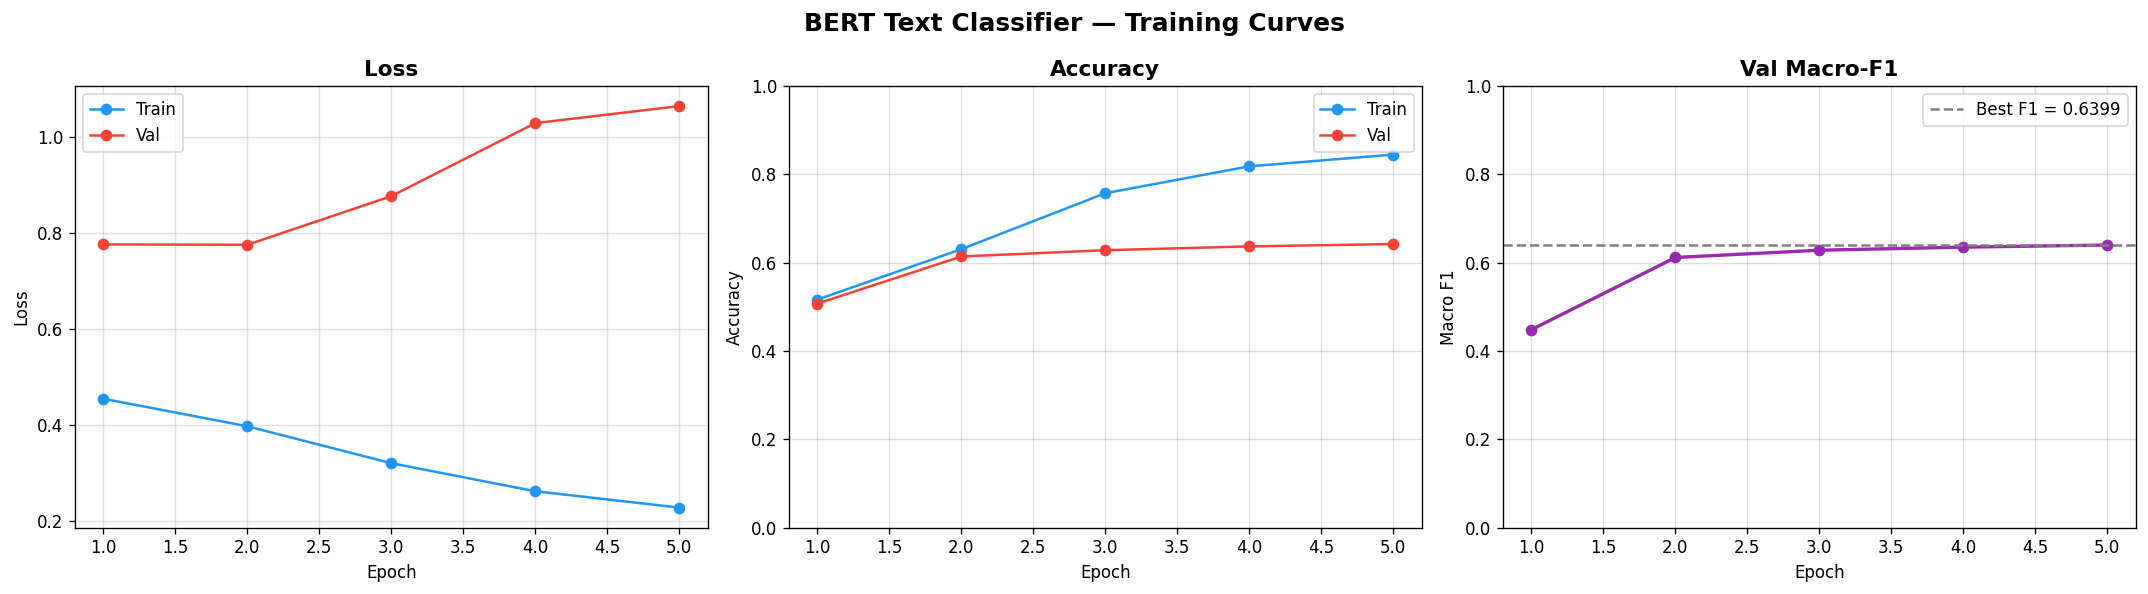

✅ Saved → /content/drive/MyDrive/MMHS150K_BERT/results/training_curves.png


In [9]:
epochs_ran = range(1, len(history["train_loss"]) + 1)
fig, axes  = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(epochs_ran, history["train_loss"], "o-", color="#2196F3", label="Train")
axes[0].plot(epochs_ran, history["val_loss"],   "o-", color="#F44336", label="Val")
axes[0].set_title("Loss", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].legend(); axes[0].grid(True, alpha=0.4)

# Accuracy
axes[1].plot(epochs_ran, history["train_acc"], "o-", color="#2196F3", label="Train")
axes[1].plot(epochs_ran, history["val_acc"],   "o-", color="#F44336", label="Val")
axes[1].set_title("Accuracy", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1); axes[1].legend(); axes[1].grid(True, alpha=0.4)

# Val F1
axes[2].plot(epochs_ran, history["val_f1"], "o-", color="#9C27B0", linewidth=2)
axes[2].axhline(max(history["val_f1"]), color="gray", linestyle="--",
                label=f"Best F1 = {max(history['val_f1']):.4f}")
axes[2].set_title("Val Macro-F1", fontsize=13, fontweight="bold")
axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Macro F1")
axes[2].set_ylim(0, 1); axes[2].legend(); axes[2].grid(True, alpha=0.4)

plt.suptitle("BERT Text Classifier — Training Curves", fontsize=15, fontweight="bold")
plt.tight_layout()

curves_path = RESULT_DIR / "training_curves.png"
plt.savefig(curves_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"✅ Saved → {curves_path}")

## Step 9 — Evaluate Best Model on Test Set

In [10]:
# ── Load best checkpoint ───────────────────────────────────────────────────
print(f"Loading best checkpoint from {best_ckpt} ...")
ckpt = torch.load(best_ckpt, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
print(f"  Best epoch: {ckpt['epoch']}  |  val_f1: {ckpt['val_f1']:.4f}")

# ── Test evaluation ────────────────────────────────────────────────────────
test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)

report_str  = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0)
report_dict = classification_report(y_true, y_pred, target_names=LABEL_NAMES,
                                    digits=4, zero_division=0, output_dict=True)
cm          = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

print("\n" + "="*65)
print("  TEST RESULTS")
print("="*65)
print(f"  Loss     : {test_loss:.4f}")
print(f"  Accuracy : {test_acc:.4f}")
print(f"  Macro F1 : {test_f1:.4f}")
print("\n" + report_str)

# ── Save metrics JSON to Drive ─────────────────────────────────────────────
metrics = {
    "task": "binary" if BINARY else "6class",
    "model": MODEL_NAME,
    "epochs_ran": len(history["train_loss"]),
    "best_epoch": int(ckpt["epoch"]),
    "history": history,
    "test": {
        "loss": test_loss,
        "accuracy": test_acc,
        "macro_f1": test_f1,
        "per_class": {
            lbl: {
                "precision": report_dict.get(lbl, {}).get("precision", 0),
                "recall":    report_dict.get(lbl, {}).get("recall",    0),
                "f1":        report_dict.get(lbl, {}).get("f1-score",  0),
                "support":   report_dict.get(lbl, {}).get("support",   0),
            } for lbl in LABEL_NAMES
        },
    },
}
metrics_path = RESULT_DIR / "metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Metrics saved → {metrics_path}")

# ── Save classification report text ───────────────────────────────────────
txt_path = RESULT_DIR / "classification_report.txt"
with open(txt_path, "w") as f:
    f.write(f"BERT — {'binary' if BINARY else '6class'}\n")
    f.write(f"Best epoch: {ckpt['epoch']} | val_f1: {ckpt['val_f1']:.4f}\n\n")
    f.write(report_str)
    f.write(f"\n\nConfusion Matrix:\n{cm}\n")
print(f"✅ Report saved  → {txt_path}")

Loading best checkpoint from /content/drive/MyDrive/MMHS150K_BERT/checkpoints/bert_best.pt ...
  Best epoch: 5  |  val_f1: 0.6399

  TEST RESULTS
  Loss     : 1.1083
  Accuracy : 0.6348
  Macro F1 : 0.6322

              precision    recall  f1-score   support

     NotHate     0.6824    0.6450    0.6632      5574
        Hate     0.5818    0.6220    0.6012      4426

    accuracy                         0.6348     10000
   macro avg     0.6321    0.6335    0.6322     10000
weighted avg     0.6379    0.6348    0.6357     10000

✅ Metrics saved → /content/drive/MyDrive/MMHS150K_BERT/results/metrics.json
✅ Report saved  → /content/drive/MyDrive/MMHS150K_BERT/results/classification_report.txt


## Step 10 — Visualise Test Results

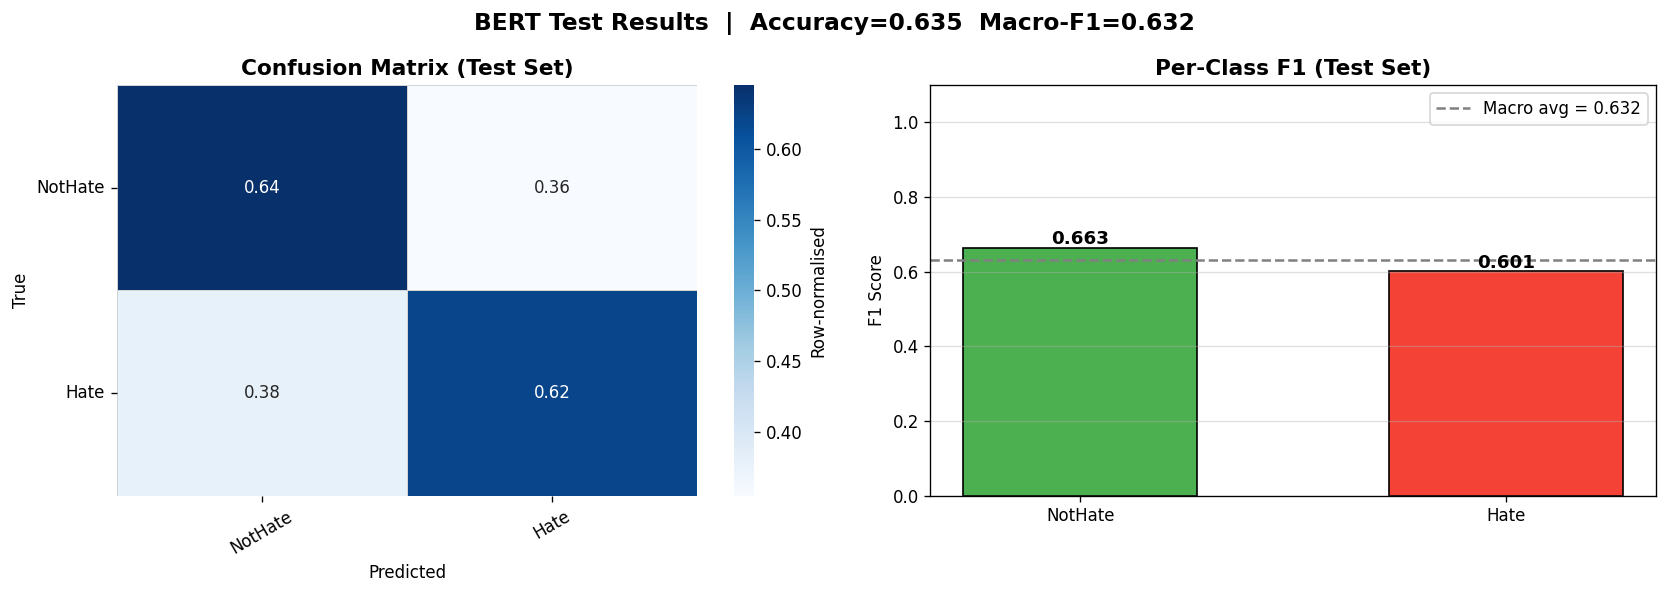

✅ Saved → /content/drive/MyDrive/MMHS150K_BERT/results/confusion_matrix.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── (A) Confusion matrix ───────────────────────────────────────────────────
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES,
            linewidths=0.5, linecolor="lightgray", ax=axes[0],
            cbar_kws={"label": "Row-normalised"})
axes[0].set_title("Confusion Matrix (Test Set)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].tick_params(axis="x", rotation=30); axes[0].tick_params(axis="y", rotation=0)

# ── (B) Per-class F1 ──────────────────────────────────────────────────────
COLORS = ["#4CAF50","#F44336","#FF9800","#9C27B0","#2196F3","#FF5722"][:NUM_CLASSES]
f1_scores = [report_dict.get(lbl, {}).get("f1-score", 0.0) for lbl in LABEL_NAMES]
bars = axes[1].bar(LABEL_NAMES, f1_scores, color=COLORS, edgecolor="black", width=0.55)
for bar, val in zip(bars, f1_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{val:.3f}", ha="center", fontsize=11, fontweight="bold")
axes[1].axhline(np.mean(f1_scores), color="gray", linestyle="--",
                label=f"Macro avg = {np.mean(f1_scores):.3f}")
axes[1].set_title("Per-Class F1 (Test Set)", fontsize=13, fontweight="bold")
axes[1].set_ylabel("F1 Score"); axes[1].set_ylim(0, 1.1)
axes[1].legend(); axes[1].grid(axis="y", alpha=0.4)

plt.suptitle(f"BERT Test Results  |  Accuracy={test_acc:.3f}  Macro-F1={test_f1:.3f}",
             fontsize=14, fontweight="bold")
plt.tight_layout()

cm_path = RESULT_DIR / "confusion_matrix.png"
f1_path = RESULT_DIR / "per_class_f1.png"
plt.savefig(cm_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"✅ Saved → {cm_path}")

## Step 11 — Save Full Model to Google Drive
Saves the HuggingFace-compatible `model.save_pretrained()` format **and** the raw PyTorch checkpoint — so you can load it from anywhere.

In [12]:
# ── 1. Save HuggingFace BERT backbone (can be loaded with from_pretrained) ─
hf_save_dir = DRIVE_ROOT / "bert_hf_model"
hf_save_dir.mkdir(parents=True, exist_ok=True)

model.bert.save_pretrained(str(hf_save_dir))          # saves config.json + model weights
tokenizer.save_pretrained(str(hf_save_dir))           # saves vocab, tokenizer config
print(f"✅ HuggingFace model + tokenizer saved → {hf_save_dir}")

# ── 2. Save full classifier state dict (head + BERT weights together) ─────
full_ckpt_path = DRIVE_ROOT / "checkpoints" / "bert_full_classifier.pt"
torch.save({
    "model_state_dict":  model.state_dict(),
    "num_classes":       NUM_CLASSES,
    "label_map":         LABEL_MAP,
    "label_names":       LABEL_NAMES,
    "binary":            BINARY,
    "model_name":        MODEL_NAME,
    "max_len":           MAX_LEN,
    "dropout":           DROPOUT,
    "best_val_f1":       best_val_f1,
    "test_acc":          test_acc,
    "test_macro_f1":     test_f1,
}, full_ckpt_path)
print(f"✅ Full classifier checkpoint saved → {full_ckpt_path}")

# ── 3. Summary of everything saved ────────────────────────────────────────
print("\n📁 Files saved to Google Drive:")
for p in sorted(DRIVE_ROOT.rglob("*")):
    if p.is_file():
        size_mb = p.stat().st_size / 1e6
        print(f"   {p.relative_to(DRIVE_ROOT)}  ({size_mb:.1f} MB)")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ HuggingFace model + tokenizer saved → /content/drive/MyDrive/MMHS150K_BERT/bert_hf_model
✅ Full classifier checkpoint saved → /content/drive/MyDrive/MMHS150K_BERT/checkpoints/bert_full_classifier.pt

📁 Files saved to Google Drive:
   bert_hf_model/config.json  (0.0 MB)
   bert_hf_model/model.safetensors  (438.0 MB)
   bert_hf_model/tokenizer.json  (0.7 MB)
   bert_hf_model/tokenizer_config.json  (0.0 MB)
   checkpoints/bert_best.pt  (1314.1 MB)
   checkpoints/bert_full_classifier.pt  (438.0 MB)
   checkpoints/bert_last.pt  (438.0 MB)
   results/classification_report.txt  (0.0 MB)
   results/confusion_matrix.png  (0.1 MB)
   results/metrics.json  (0.0 MB)
   results/training_curves.png  (0.1 MB)


## Step 12 — Verify Saved Model (Quick Inference Test)
Reload from Drive and run a few sample predictions to confirm everything was saved correctly.

In [13]:
# ── Reload from Drive checkpoint ──────────────────────────────────────────
verify_ckpt = torch.load(full_ckpt_path, map_location=DEVICE)

verify_model = BertTextClassifier(
    model_name=verify_ckpt["model_name"],
    num_classes=verify_ckpt["num_classes"],
    dropout=verify_ckpt["dropout"],
).to(DEVICE)
verify_model.load_state_dict(verify_ckpt["model_state_dict"])
verify_model.eval()

verify_tokenizer = BertTokenizerFast.from_pretrained(str(hf_save_dir))

print("✅ Model reloaded successfully from Drive\n")
print(f"   Saved test accuracy : {verify_ckpt['test_acc']:.4f}")
print(f"   Saved test macro-F1 : {verify_ckpt['test_macro_f1']:.4f}")
print(f"   Classes : {verify_ckpt['label_names']}\n")

# ── Sample inference ───────────────────────────────────────────────────────
samples = [
    "I love everyone and hope we can all get along",
    "All those people should be thrown out of this country",
    "Great game today, the team played brilliantly!",
    "You're a disgusting retard and nobody wants you here",
]

print("Sample predictions:")
print("-" * 55)
with torch.no_grad():
    for text in samples:
        enc = verify_tokenizer(
            text, padding="max_length", truncation=True,
            max_length=verify_ckpt["max_len"], return_tensors="pt",
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = verify_model(**enc)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred   = int(torch.argmax(logits, dim=1).item())
        label  = verify_ckpt["label_names"][pred]
        conf   = probs[pred] * 100
        emoji  = "✅" if label == "NotHate" else "🚨"
        print(f"{emoji} [{label:<8}  {conf:5.1f}%]  \"{text[:55]}\"")

print("\n✅ All done! Your BERT model is trained and saved.")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model reloaded successfully from Drive

   Saved test accuracy : 0.6348
   Saved test macro-F1 : 0.6322
   Classes : ['NotHate', 'Hate']

Sample predictions:
-------------------------------------------------------
✅ [NotHate    96.3%]  "I love everyone and hope we can all get along"
✅ [NotHate    94.4%]  "All those people should be thrown out of this country"
✅ [NotHate    99.6%]  "Great game today, the team played brilliantly!"
🚨 [Hate       98.3%]  "You're a disgusting retard and nobody wants you here"

✅ All done! Your BERT model is trained and saved.
